In [83]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

from timeit import default_timer
import pandas as pd
import numpy as np
from collections import Counter
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


class Timer(object):
    """Timer class.

    `Original code <https://github.com/miguelgfierro/pybase/blob/2298172a13fb4a243754acbc6029a4a2dcf72c20/log_base/timer.py>`_.
    
    Examples:
        >>> import time
        >>> t = Timer()
        >>> t.start()
        >>> time.sleep(1)
        >>> t.stop()
        >>> t.interval < 1
        True
        >>> with Timer() as t:
        ...   time.sleep(1)
        >>> t.interval < 1
        True
        >>> "Time elapsed {}".format(t) #doctest: +ELLIPSIS
        'Time elapsed 1...'
    """

    def __init__(self):
        self._timer = default_timer
        self._interval = 0
        self.running = False

    def __enter__(self):
        self.start()
        return self

    def __exit__(self, *args):
        self.stop()

    def __str__(self):
        return "{:0.4f}".format(self.interval)

    def start(self):
        """Start the timer."""
        self.init = self._timer()
        self.running = True

    def stop(self):
        """Stop the timer. Calculate the interval in seconds."""
        self.end = self._timer()
        try:
            self._interval = self.end - self.init
            self.running = False
        except AttributeError:
            raise ValueError(
                "Timer has not been initialized: use start() or the contextual form with Timer() as t:"
            )

    @property
    def interval(self):
        """Get time interval in seconds.

        Returns:
            float: Seconds.
        """
        if self.running:
            raise ValueError("Timer has not been stopped, please use stop().")
        else:
            return self._interval

In [ ]:
class FrequencyRecommender:
    def __init__(self, behaviors_file, news_file, time_window=604800, num_clicks=10, recency_weight=0.6, popularity_weight=0.4):
        """
        Initializes the recommender with paths to the data files and necessary parameters.
        
        :param behaviors_file: Path to the behaviors dataset (CSV file).
        :param news_file: Path to the news dataset (CSV file).
        :param time_window: Time window for the data (default 1 week in seconds).
        :param num_clicks: Number of recent clicks to consider for each article (default 10).
        :param recency_weight: Weight for recency in the final score (default 0.6).
        :param popularity_weight: Weight for popularity in the final score (default 0.4).
        """
        # Load datasets
        self.behaviors_file = behaviors_file
        self.news_file = news_file
        self.TIME_WINDOW = time_window  # Default: One week in seconds
        self.NUM_CLICKS = num_clicks
        self.RECENCY_WEIGHT = recency_weight
        self.POPULARITY_WEIGHT = popularity_weight
        
        # Load data
        self.behaviors_df = pd.read_csv(self.behaviors_file, sep='\t', header=None, names=["Impression ID", "User ID", "Time", "History", "Impressions"])
        self.news_df = pd.read_csv(self.news_file, sep='\t', header=None, names=["News ID", "Category", "SubCategory", "Title", "Abstract", "URL", "Title Entities", "Abstract Entities"])

        # Data preparation
        self.prepare_data()

    def prepare_data(self):
        """Preprocess the behaviors data and filter by the last week."""
        # Drop rows with missing Impressions
        self.behaviors_df = self.behaviors_df.dropna(subset=["Impressions"])

        # Convert 'Time' to datetime and compute epoch timestamp
        self.behaviors_df['Time'] = pd.to_datetime(self.behaviors_df['Time'])
        self.behaviors_df['Timestamp'] = self.behaviors_df['Time'].apply(lambda x: x.timestamp())

        # Determine the most recent interaction timestamp (across all users)
        self.latest_time = self.behaviors_df['Timestamp'].max()

        # Filter the dataset to only include interactions from the past week
        self.behaviors_df = self.behaviors_df[self.behaviors_df['Timestamp'] >= (self.latest_time - self.TIME_WINDOW)]

        # Function to parse the Impressions string and extract clicked news IDs (where label is "1")
        self.behaviors_df['Clicked_Articles'] = self.behaviors_df['Impressions'].apply(self.parse_impressions)

    def parse_impressions(self, impressions_str):
        """Parses the impressions string and returns a list of clicked articles."""
        clicked = []
        for item in impressions_str.split():
            news_id, click_label = item.split('-')
            if click_label == "1":
                clicked.append(news_id)
        return clicked

    def collect_to_list(self):
        """Collect all clicked articles into a list."""
        read_articles = []
        for index, row in self.behaviors_df.iterrows():
            read_articles.extend(row["Clicked_Articles"])
        return read_articles

    def sort_by_count(self, articles):
        """Sort articles by the click count."""
        counter = Counter(articles)
        sorted_articles = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        return dict(sorted_articles)

    def get_mean_timestamp(self, news_id, num_clicks=10):
        """Get the mean timestamp of the last N clicks for each article."""
        interactions = self.behaviors_df[self.behaviors_df['Clicked_Articles'].apply(lambda x: news_id in x)]
        interactions = interactions.sort_values(by='Timestamp', ascending=False)
        interactions = interactions.head(num_clicks)
        
        if interactions.empty:
            return None
        
        mean_timestamp = interactions['Timestamp'].mean()
        return mean_timestamp

    def calculate_decay(self, row):
        """Calculate the decay weight based on recency."""
        if row['Mean Timestamp'] is None:
            return 0
        
        # Exponential decay based on time difference from latest_time
        time_difference = self.latest_time - row['Mean Timestamp']
        decay_weight = math.exp(-time_difference / (self.TIME_WINDOW / 7)) * 100  # Granularity: per day
        return decay_weight

    def calculate_score(self, sorted_df):
        """Calculate the recommendation score based on recency and popularity."""
        # Calculate decay weight
        sorted_df['Decay Weight'] = sorted_df.apply(self.calculate_decay, axis=1)
        
        # Calculate final score (based on recency and popularity)
        sorted_df['Score'] = sorted_df['Decay Weight'] * sorted_df['Click Count']
        
        # Normalize Scores to range from 0 to 1
        min_score = sorted_df['Score'].min()
        max_score = sorted_df['Score'].max()
        sorted_df['Normalized Score'] = (sorted_df['Score'] - min_score) / (max_score - min_score)
        
        return sorted_df

    def get_top_recommendations(self):
        """Main method to get the top recommendations."""
        # Create DataFrame for sorted articles (NewsID and Click Count)
        sorted_articles = self.sort_by_count(self.collect_to_list())
        sorted_articles_list = list(sorted_articles.items())
        sorted_df = pd.DataFrame(sorted_articles_list, columns=["News ID", "Click Count"])

        # Get the mean timestamp of the last N clicks for each article
        sorted_df['Mean Timestamp'] = sorted_df['News ID'].progress_apply(self.get_mean_timestamp)

        # Calculate final scores based on recency and popularity
        sorted_df = self.calculate_score(sorted_df)

        # Sort the DataFrame by Normalized Score
        final_recommendations = sorted_df[['News ID', 'Click Count', 'Decay Weight', 'Mean Timestamp', 'Normalized Score']].sort_values(by='Normalized Score', ascending=False)

        # Convert Mean Timestamp to datetime format (no milliseconds)
        final_recommendations['Mean Timestamp'] = pd.to_datetime(final_recommendations['Mean Timestamp'], unit='s').dt.floor('S')

        return final_recommendations

    def visualize_results(self, final_recommendations):
        """Visualizes the results of the recommender model."""
        # Plot 1: Distribution of recommendation scores
        plt.figure(figsize=(10, 6))
        sns.histplot(final_recommendations['Normalized Score'], bins=30, kde=True)
        plt.title('Distribution of Recommendation Scores')
        plt.xlabel('Normalized Score')
        plt.ylabel('Frequency')
        plt.show()

        # Plot 2: Top 15 Articles by Click Count
        top_articles_by_clicks = final_recommendations[['News ID', 'Click Count']].head(15)
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Click Count', y='News ID', data=top_articles_by_clicks.sort_values(by='Click Count', ascending=False), palette='viridis')
        plt.title('Top 10 Articles by Click Count')
        plt.xlabel('Click Count')
        plt.ylabel('News ID')
        plt.show()

        # Plot 3: Top 15 Articles by Recency Score
        top_articles_by_score = final_recommendations[['News ID', 'Decay Weight']].head(15)
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Decay Weight', y='News ID', data=top_articles_by_score.sort_values(by='Decay Weight', ascending=False), palette='plasma')
        plt.title('Top 10 Articles by Decay Weight')
        plt.xlabel('Decay Weight')
        plt.ylabel('News ID')
        plt.show()

In [ ]:
# Example usage:
recommender = FrequencyRecommender(
    behaviors_file="../data/raw/MINDsmall_dev/behaviors.tsv",
    news_file="../data/raw/MINDsmall_dev/news.tsv",
    time_window=604800,  # One week in seconds
    num_clicks=10,  # Get the last 10 clicks
)

# Get top recommendations
top_recommendations = recommender.get_top_recommendations()

100%|██████████| 2212/2212 [00:15<00:00, 144.25it/s]
/var/folders/bb/_8p1dld53435pgwnx7msh2g80000gn/T/ipykernel_89809/2760772538.py:122: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  final_recommendations['Mean Timestamp'] = pd.to_datetime(final_recommendations['Mean Timestamp'], unit='s').dt.floor('S')


,News ID,Click Count,Decay Weight,Mean Timestamp,Normalized Score
0,N31958,8042,67.963128,2019-11-15 14:41:54,1.000000
2,N5940,4191,92.965032,2019-11-15 22:13:00,0.712833
1,N36779,4688,58.426375,2019-11-15 11:04:11,0.501106
5,N30290,2853,92.551807,2019-11-15 22:06:35,0.483079
3,N20036,3826,63.160156,2019-11-15 12:56:22,0.442093
7,N24802,2247,75.920737,2019-11-15 17:21:21,0.312077
9,N53572,1826,87.669099,2019-11-15 20:48:32,0.292846
4,N23513,2900,54.791166,2019-11-15 09:31:41,0.290670
6,N58251,2536,62.610133,2019-11-15 12:43:46,0.290459
10,N11390,1717,87.933316,2019-11-15 20:52:52,0.276191


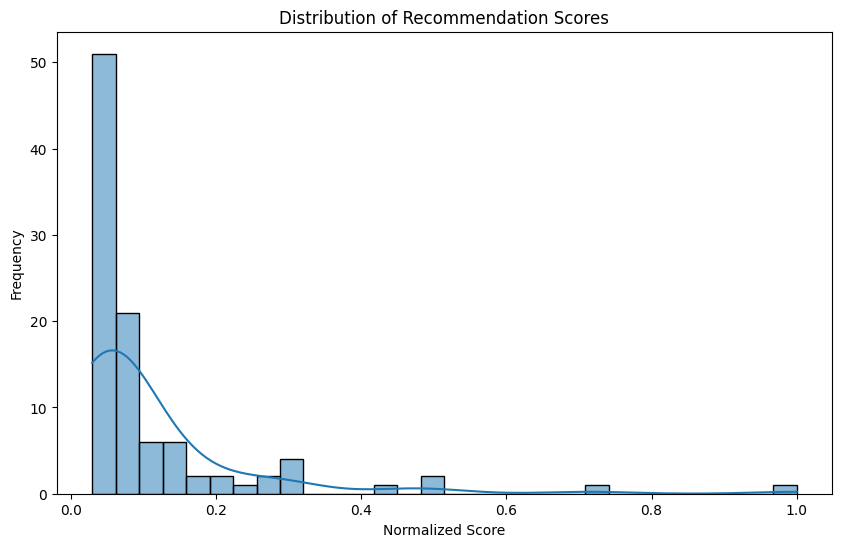

/var/folders/bb/_8p1dld53435pgwnx7msh2g80000gn/T/ipykernel_89809/2760772538.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Click Count', y='News ID', data=top_articles_by_clicks.sort_values(by='Click Count', ascending=False), palette='viridis')


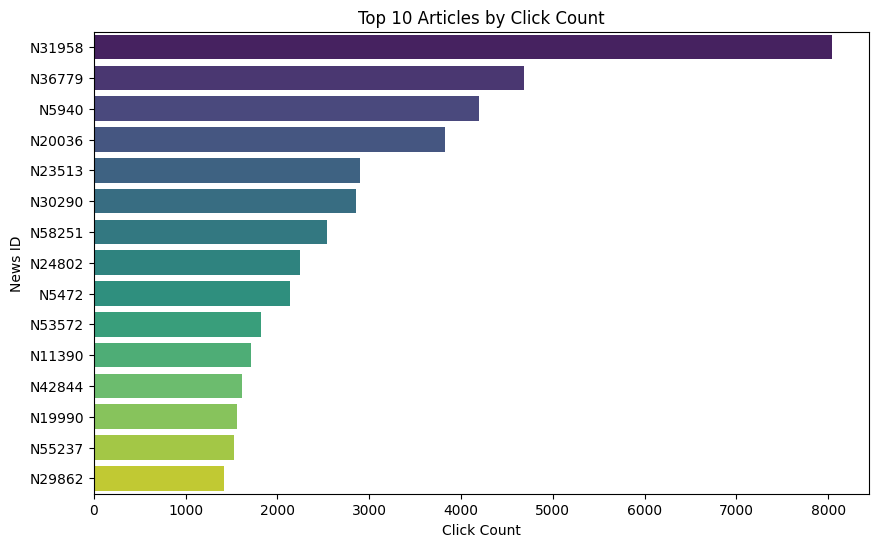

/var/folders/bb/_8p1dld53435pgwnx7msh2g80000gn/T/ipykernel_89809/2760772538.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Decay Weight', y='News ID', data=top_articles_by_score.sort_values(by='Decay Weight', ascending=False), palette='plasma')


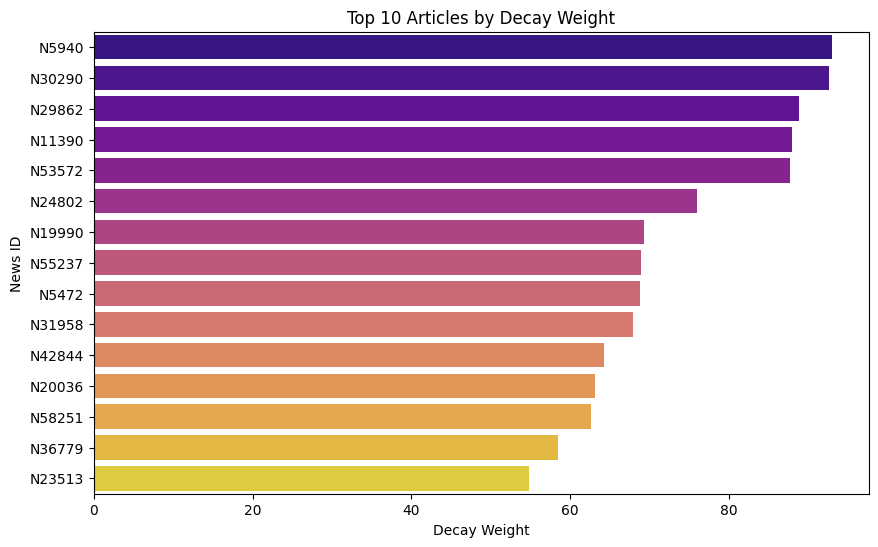

In [90]:
display(top_recommendations.head(10))
recommender.visualize_results(top_recommendations.head(100))